# Exercise 3
## Generative adversarial networks
### Generating of MNIST digits with a GAN

First we import the modules we need

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets

Check that we're running on GPU, and initialize our device

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


Setup our MNIST dataloaders

In [3]:
batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Implement your **generator** network as a fully connected neural network.

You could start with a network that:
* takes as input a 100 long vector
* has four hidden layers with 2848 neurons
* uses LeakyReLU as the activation function
* uses BatchNorm
* has Tanh as the last layer (we work with MNIST in the -1 to 1 range)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fully_connected1 = nn.Sequential(
            nn.Linear(100, 2848),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2848),
            nn.Linear(2848, 2848),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2848),
            nn.Linear(2848, 2848),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2848),
            nn.Linear(2848, 2848),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2848),
            nn.Linear(2848, 2848),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2848),
            )
        
        self.fully_connected2 = nn.Sequential(
            nn.Linear(2848, 784),
            nn.Tanh(),
        )
        
    def forward(self, x):
        x = self.fully_connected1(x)
        x = self.fully_connected2(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

In [5]:
class Generator_dcgan(nn.Module):
    def __init__(self):
        super(Generator_dcgan, self).__init__()
        self.fully_connected = nn.Sequential(
            nn.Linear(100, 30*7*7), # 64*100 -> 1470
            nn.ReLU(),
            nn.BatchNorm1d(30*7*7),
            )
        
        self.conv0 = nn.Sequential(
            nn.ConvTranspose2d(30, 20, 4, 2, 1), # 1470 -> 64*10*14*14
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(20, 10, 4, 2, 1), # -> 64*10*28*28
            nn.ReLU(),
            nn.BatchNorm2d(10),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 1, 3, 1, 1), # -> 64*1*28*28
            nn.Tanh(),
        )
        
    def forward(self, x):
        x = self.fully_connected(x)
        x = x.view(x.size(0), 30, 7, 7) # reshape
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

Implement your **discriminator** network as a fully connected neural network

Start out with a network that
* takes as input an $28\times28$ image
* has three hidden layers with [1024, 512, 256] neurons respectively
* uses LeakyReLU as the activation function
* uses Dropout
* has no activation on the final layer (we will call sigmoid if we want a probability)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fully_connected1 = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(),
            )
        self.fully_connected2 = nn.Sequential(
            nn.Linear(256, 1),
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fully_connected1(x)
        x = self.fully_connected2(x)
        return x

In [7]:
class Discriminator_spectral(nn.Module):
    def __init__(self):
        super(Discriminator_spectral, self).__init__()
        self.fully_connected1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(28*28, 1024)),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.utils.spectral_norm(nn.Linear(1024, 512)),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(),
            nn.Dropout(),
            )
        self.fully_connected2 = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(256, 1)),
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fully_connected1(x)
        x = self.fully_connected2(x)
        return x

In [8]:
class Discriminator_dcgan(nn.Module):
    def __init__(self):
        super(Discriminator_dcgan, self).__init__()
        self.conv0 = nn.Sequential(
            nn.Linear(28*28, 1025),
            nn.LeakyReLU(),
            nn.Dropout(),
            )
        self.conv1 = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(),
            nn.Dropout(),
            )
        self.conv2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(),
            )
        self.fully_connected = nn.Sequential(
            nn.Linear(256, 1),
        )
    
    def forward(self, x):
        print(x.shape)
        x = self.fully_connected1(x)
        x = self.fully_connected2(x)
        x = x.view(x.size(0), -1) 
        return x

Now let's train our model

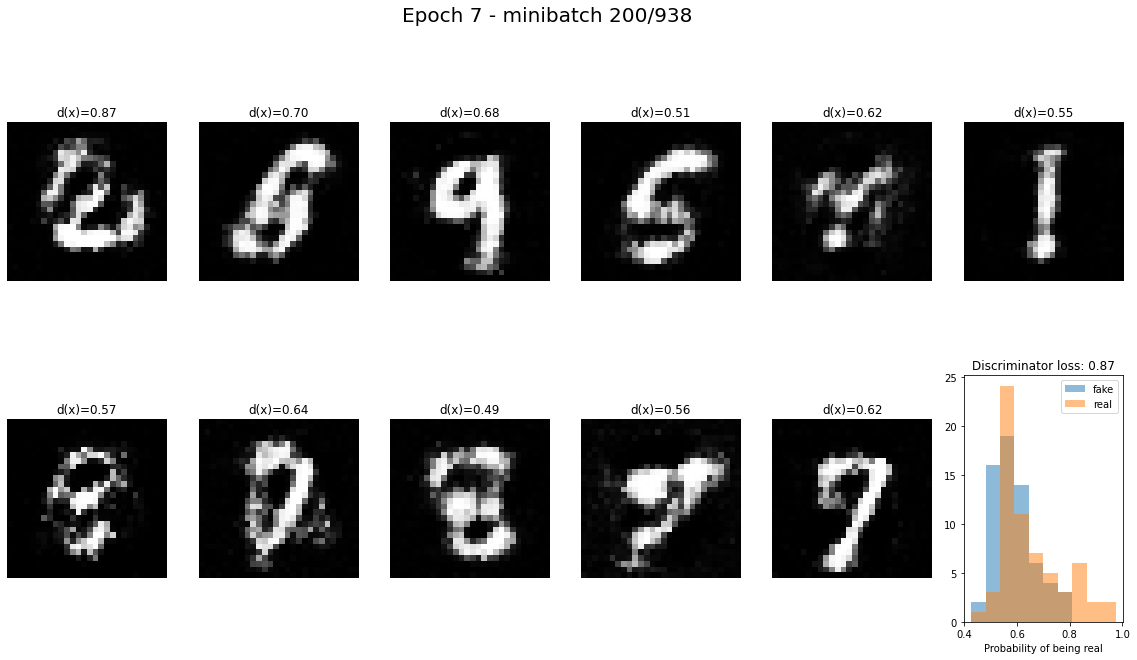

In [ ]:
#Initialize networks
d = Discriminator().to(device)
# d = Discriminator_spectral().to(device)
# d = Discriminator_dcgan().to(device)
g = Generator().to(device)
# g = Generator_dcgan().to(device)
d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
discriminator_final_layer = torch.sigmoid

arr_d_loss = []
arr_g_loss = []
arr_d_real = []
arr_d_fake = []

for epoch in tqdm(range(num_epochs), unit='epoch'):
    for minibatch_no, (x, target) in tqdm(enumerate(train_loader), unit='minibatch'):
        x_real = x.to(device)*2-1 #scale to (-1, 1) range
        z = torch.randn(x.shape[0], 100).to(device)
        # Forward pass
        x_fake = g(z)
        #Update discriminator
        d.zero_grad() #remember to detach x_fake before using it to compute the discriminator loss
        #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.
        x_fake_detached = x_fake.detach()
        d_real = - torch.mean(F.logsigmoid(d(x_real)))
        d_fake = - torch.mean(F.logsigmoid(1-d(x_fake_detached)))
        d_loss = d_real + d_fake
        # d_loss = - torch.mean(d(x_real) - d(x_fake_detached))
        d_loss.backward()
        d_opt.step()

        #Update generator
        g.zero_grad() # detach
        g_loss = - torch.mean(F.logsigmoid(d(x_fake)))
        # g_loss = - torch.mean(d(x_fake))
        g_loss.backward()
        g_opt.step()
        
        assert(not np.isnan(d_loss.item()))
        #Plot results every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad():
                P = discriminator_final_layer(d(x_fake))
                for k in range(11):
                    x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(x_fake_k, cmap='gray')
                    subplots[k].set_title('d(x)=%.2f' % P[k])
                    subplots[k].axis('off')
                z = torch.randn(batch_size, 100).to(device)
                H1 = discriminator_final_layer(d(g(z))).cpu()
                H2 = discriminator_final_layer(d(x_real)).cpu()
                plot_min = min(H1.min(), H2.min()).item()
                plot_max = max(H1.max(), H2.max()).item()
                subplots[-1].cla()
                subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].legend()
                subplots[-1].set_xlabel('Probability of being real')
                subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())
                
                title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                plt.gcf().suptitle(title, fontsize=20)
                display.display(plt.gcf())
                display.clear_output(wait=True)

                arr_d_loss.append(d_loss.detach().cpu().item())
                arr_g_loss.append(g_loss.detach().cpu().item())
                arr_d_real.append(d_real.detach().cpu().item())
                arr_d_fake.append(d_fake.detach().cpu().item())

In [ ]:
d(x_fake).min()

tensor(6.0654, device='cuda:0', grad_fn=<MinBackward1>)

In [ ]:
plt.plot(F.logsigmoid(torch.tensor(arr_d_real)))
plt.plot(F.logsigmoid(torch.tensor(arr_d_fake)))
plt.legend(('Discriminator real', 'Generator fake'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()

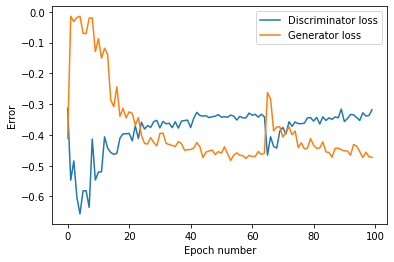

In [10]:
plt.plot(F.logsigmoid(torch.tensor(arr_d_loss)))
plt.plot(F.logsigmoid(torch.tensor(arr_g_loss)))
plt.legend(('Discriminator loss', 'Generator loss'))
plt.xlabel('Epoch number')
plt.ylabel('Error')
plt.show()

Do you get a model to generate nice images?

The plot shows probabilities of real and generated digits being classified as real. Is the discriminator able to distinguish real from fake? If not, try increasing the capacity of the discriminator.
Feel free to change the architecture as you see fit.

## Additional tasks
* Change the architecture to get better results
* Implement another loss (for example WGAN with SN)
* Convert your network to a DCGAN
* Visualize what happens when you interpolate between to points in the latent space
* Generate images from FashionMNIST

### Harder tasks:
* Add data augmentation to fake and real images
* Use the data augmentation to make a Consistency Regularization-GAN
* Convert your architecture into a AC-GAN